# Projeto 2

## Precessão do periélio de Mercúrio

As leis de Kepler foram desenvolvidas com base em medidas (extremamente acuradas) realizadas a olho nú. Quando equipamentos mais precisos para medição de posição e tempo foram desenvolvidos, ficou claro que a trajetória de Mercúrio não era como esperado uma elipse, mas sim uma elipse com um deslocamento contínuo em seu periélio.

O deslocamento pode ser medido como de 566 arco-segundos por século. Posteriormente se descobriu que uma boa parte desse deslocamento é devida à influência dos outros planetas do sistema solar (além do Sol). Os cálculos prevêm o deslocamento de 523 arco-segundos por século. Resta então explicar aproximadamente 43 arco-segundos por século do deslocamento.

A explicação somente surgiu com o desenvolvimento da teoria da relatividade geral, que altera a lei da gravitação. Considerando o fator mais significativo, a força de gravitação fica adaptada para incluir fator relativístico da seguinte forma (escrita para a interação entre o Sol e Mercúrio):

$$ F_G = \frac{GM_SM_M}{r^2}\left(1 + \frac{\alpha}{r^2}\right),$$

onde $\alpha\approx1.1\cdot10^{-8}\,\mathrm{UA}^2$ (para Mercúrio), $GM_S=4\pi^2\,\mathrm{UA}^3/\mathrm{ano}^2$ e a força é na direção radial para dentro. Projetando a força nas direções $(x,y)$ e considerando o Sol na origem:

\begin{eqnarray}
\frac{d^2x}{dt^2} & = & -\frac{GM_S}{r^3}\left(1 + \frac{\alpha}{r^2}\right)x\\
\frac{d^2y}{dt^2} & = & -\frac{GM_S}{r^3}\left(1 + \frac{\alpha}{r^2}\right)y\\
\end{eqnarray}

onde $r = \sqrt{x^2+y^2}.$

Para completar, usamos as seguintes condições iniciais com Mercúrio inicialmente no seu ponto mais afastado do Sol (veja seção 4.3 do livro *Computational Physics* de Giordano e Nakanishi para explicação das expressões):

\begin{eqnarray}
x(0) & = & (1+e)a\\
y(0) & = & 0\\
v_x(0) & = & 0\\
v_y(0) & = & \sqrt{\frac{GM_S(1-e)}{a(1+e)}},
\end{eqnarray}

onde para Mercúrio $a \approx 0.39\,\mathrm{UA}$ (eixo maior da elipse) e $e\approx0.206$ (excentricidade).

O projeto consiste em avaliar a contribuição do fator relativístico para a precessão do periélio de Mercúrio.

Você deve proceder da seguinte forma:
1. Implemente código para integrar a trajetória de Mercúrio usando as equações e condições iniciais acima.
1. Simule por aproximadamente 10 períodos de revolução para $\alpha=0$ e plote um gráfico da trajetória. Este é o caso não-relativístico, e a trajetória deve ser uma elipse perfeita com o sol em um dos focos. Use um tamanho de passo de tempo suficientemente preciso. Lembre-se de que o período de rotação de Mercúrio é de aproximadamente 88 dias.
1. Repita a simulação, mas agora com $\alpha=0.01$. Este é um caso com fator relativístico grande, o que significa que a precessão deve ser claramente visível na trajetória.
1. O valor real de $\alpha=1.1\cdot10^{-8}$ para Mercúrio é extremamente baixo, o que significa que seria necessário simular o sistema por um grande intervalo de tempo para permitir avaliar a taxa de precessão. Ao invés disso, vamos seguir um outro método: Vamos avaliar a taxa de precessão para diversos valores de $\alpha$. Veremos então que ela varia linearmente com $\alpha$. Avaliaremos então a expressão da dependência linear e calcularemos a taxa de precessão usando o $\alpha$ conhecido de Mercúrio, conforme descrito nos passos abaixo.
1. O primeiro passo é encontrar um método para marcar um ponto específico da elipse, para podermos avaliar como ele está se deslocando com o tempo. Para isso, usaremos o ponto mais afastado do Sol. Esse ponto pode ser determinado pelo seguinte raciocínio: O ponto mais afastado é aquele para o qual antes de chegar nele as distâncias vão aumentando, e depois que ele passa as distâncias vâo diminuindo. Dizendo de outra forma, ele é um ponto onde a derivada da distância é zero, e a derivada é positiva antes dele e negativa depois dele. Ao invés de usar a distância, usaremos a distância ao quadrado (pois o ponto de máximo é o mesmo).
$$\frac{d}{dt}r^2 = \frac{d}{dt}(x^2 + y^2) = 2\left(x\frac{dx}{dt} + y\frac{dy}{dt}\right).$$
O fator 2 pode ser ignorado para nossos propósitos (não afeta o sinal da derivada). Queremos então os valores de $t$ para os quais a expressão
$$x v_x + y v_y$$
passa de positiva para negativa. Os valores de $x, y, v_x$ e $v_y$ são calculados durante a solução das equações diferenciais. Usando os valores retornados pela rotina de integração, calcule os valores da expressão acima e encontre os pontos onde ele passa de positivo (ou zero) para negativo (ou zero). Para nossos propósitos, basta guardar um desses pontos (o último positivo ou o primeiro negativo) como o ponto de transição. Encontre os valores dos ângulos entre o eixo $x$ e o raio da posição de Mercúrio (dica: Esse ângulo pode ser calculado usando `numpy.arctan2`, veja documentação).
1. Plote um gráfico com os ângulos contra o tempo desses pontos e verifique que eles formam uma reta (aproximadamente) que passa pela origem.
1. Use a função `curve_fit` do módulo `scipy.optimize` para fazer um ajuste da função $\theta = \rho t$ a esses pontos (a função `curve_fit` irá retornar, entre outros, o valor desejado de $\rho$, que é a taxa de precessão para o $\alpha$ usado na simulação).
1. Repita a simulação e o ajuste de curva para 20 valores de $\alpha$ entre 0 e 0.002, encontrando os valores de $\rho$ para cada um dos $\alpha$.
1. Plote o gráfico de $\rho$ versus $\alpha$ e verifique que ele é uma linha reta que passa pela origem.
1. Use novamente `curve_fit`, mas agora para ajustar $\rho = c \alpha$ e econtrar o melhor valor de $c$.
1. Usando o valor de $c$ encontrado e o valor de $\alpha$ conhecido para Mercúrio (acima), calcule a taxa de precessão de Mercúrio devida a efeitos relativísticos e confira com o valor esperado (acima).

In [55]:
import numpy as np 
import scipy.optimize as op
import matplotlib.pyplot as plt
from scipy.integrate import ode
%matplotlib inline

In [56]:
def deriv(t,xyab,alpha,A,e,Gms): # função para integração do problema
    x,y,a,b = xyab
    r = np.sqrt((x**2+y**2))
    return[a,b,-(Gms/r**3)*(1+(alpha/r**2))*x,-(Gms/r**3)*(1+(alpha/r**2))*y]

def simula(alpha):
    Gms = 4*np.pi**2 # parâmetros
    A = 0.39
    e = 0.206
    t0 = 0
    delta_t = 0.0001 # intervalo de tempo
    iniciais =[(1+e)*A,0,0,np.sqrt(((Gms*(1-e))/(A*(1+e))))] # lista com os estados iniciais
    r = ode(deriv)
    r.set_initial_value(iniciais)
    r.set_f_params(alpha,A,e,Gms)
    rev = 0 # variável que conta o número de revoluções
    xyab_1 = [iniciais] # lista que guarda os estados 
    xf = [] # lista que guarda a coordenada x do máximo depois de uma revolução
    yf = [] # lista que guarda a coordenada y do máximo depois de uma revolução
    t_theta = [] # lista que guarda o tempo que ocorreu o máximo, necessário para a linearização
    while r.successful() and rev<10: # a condição de parada é que depois de 10 revoluções a integração pare
        new_t = r.t + delta_t
        new_xyab = r.integrate(new_t)
        old_xyab = xyab_1[-1] # lista que guarda os estados anteriores 
        xyab_1.append(new_xyab) # a condição abaixo corresponde à mudança de positivo
        #para negativo de r² para que conte uma revolução e guarde os estados 
        if (new_xyab[0]*new_xyab[2] + new_xyab[1]*new_xyab[3]) < 0  and (old_xyab[0]*old_xyab[2] + old_xyab[1]*old_xyab[3]) > 0:
            rev = rev + 1 # contagem da revolução
            xf.append(new_xyab[0]) #append dos estados depois do máximo
            yf.append(new_xyab[1]) 
            t_theta.append(new_t) 
        old_xyab = new_xyab 
    xyab_1 = np.array(xyab_1) # conversão da lista para array para indexação
    xs = xyab_1[:,0]
    ys = xyab_1[:,1]
    return xs,ys,xf,yf,t_theta

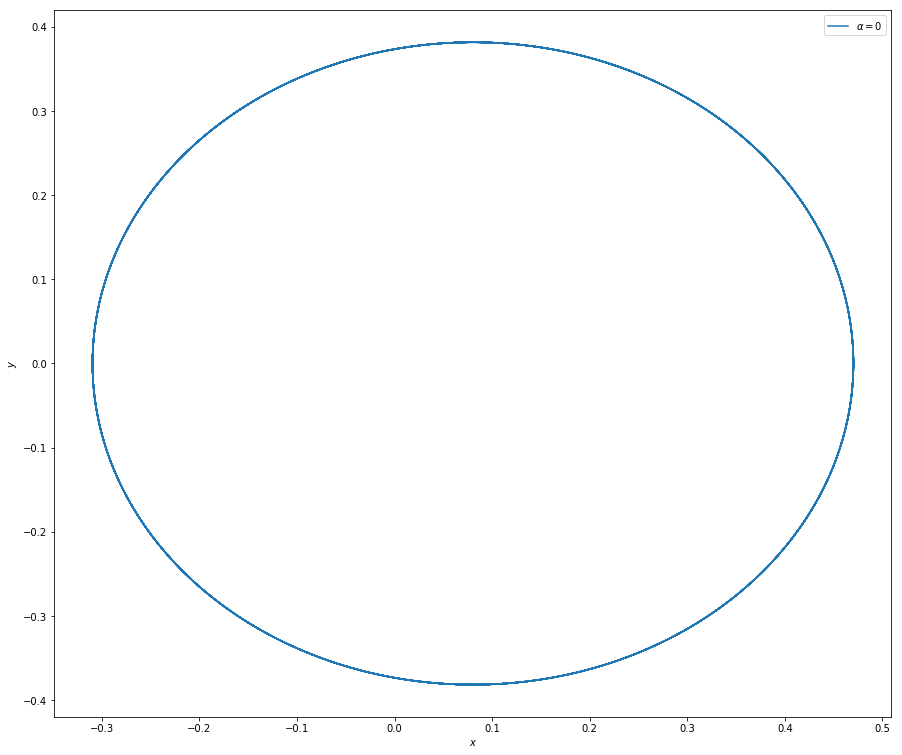

In [57]:
    x,y,xf,yf,t_theta = simula(0)
    plt.figure(figsize=(15,13)) # plot da órbita sem precessão
    k,= plt.plot(x,y,label = r'$\alpha = 0$')
    plt.legend(handles=[k])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()

   Vê-se que claramente a trajetória para o caso em que $\alpha = 0$, ou seja, não há precessão, a trajetória é uma elipse, como previsto.
   
   Agora realizando a simulação para o caso em que $\alpha = 0.01$, um caso em que a precessão devido ao efeito relativístico é grande, tem-se:

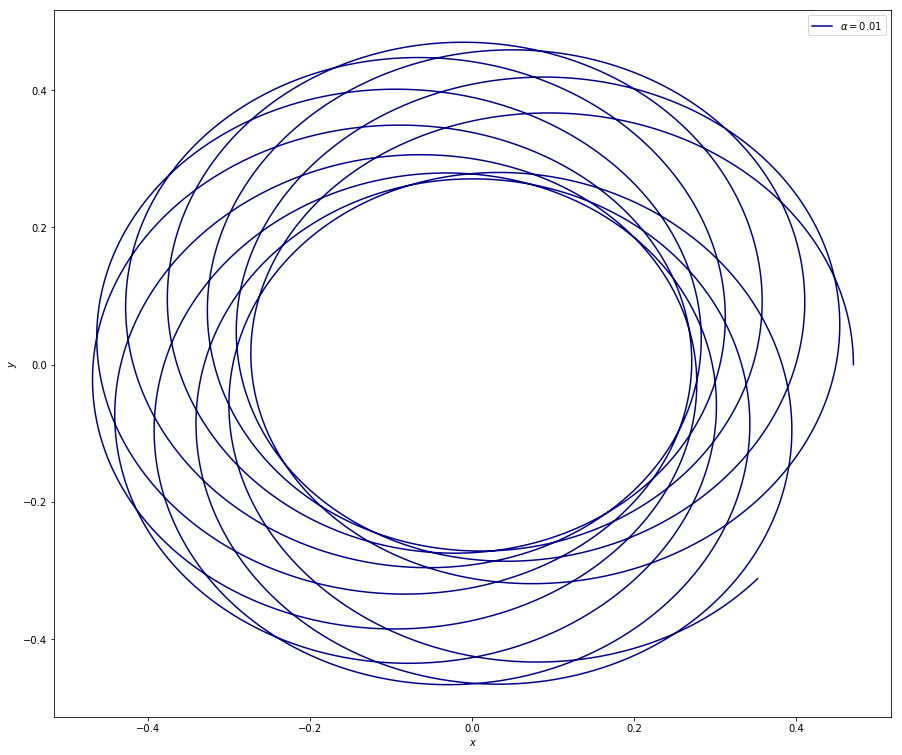

In [58]:
    result_1 = simula(0.01) # plot da órbita com alpha 
    plt.figure(figsize=(15,13))
    k,= plt.plot(result_1[0],result_1[1],label = r'$\alpha = 0.01$',color = 'darkblue')
    plt.legend(handles=[k])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()

 Agora realizar-se-á a linearização dos ângulos $\theta$ em relação ao eixo $x$ que dão a posição do afélio depois de uma revolução para vários valores de $\alpha$, no intervalo pedido:

In [59]:
x,y,xf,yf,t_theta = simula(0.001) # simulando para um valor intermediário no intervalo pedido
def cal_theta(xf,yf): # função que calcula o ângulo theta
    theta = [] 
    for i in range (0,len(xf)):
        theta.append(np.arctan2(yf[i],xf[i]))
    return theta
theta = cal_theta(xf,yf)

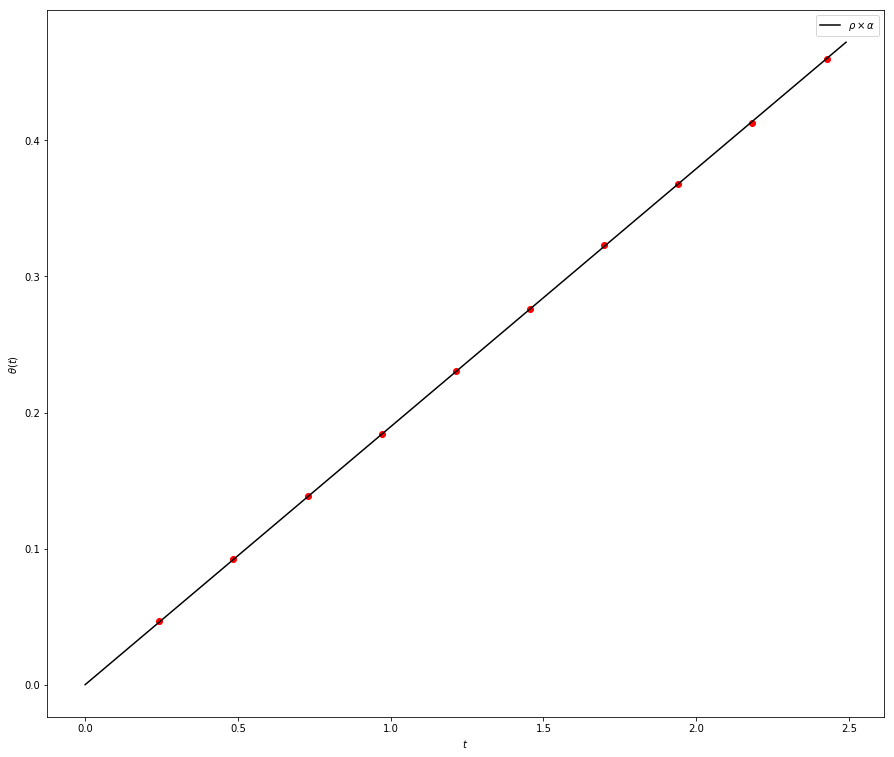

In [60]:
    plt.figure(figsize=(15,13)) # plot de theta por t onde os máximos ocorreram
    plt.scatter(t_theta,theta,color = 'red') 
    fit_t_theta= np.arange(0,2.5,0.01) # array de valores para o plot da curva
    fit_theta = list(op.curve_fit(func,t_theta,theta))[0]*fit_t_theta# theta = rho*alpha
    k_1,= plt.plot(fit_t_theta,fit_theta,label = r'$\rho \times \alpha$',color = 'black')#plot da curva fitada
    plt.legend(handles=[k_1])
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\theta(t)$')
    plt.show()

   Logo vê-se que o gráfico é uma linha reta que passa na origem,como o suposto.
   
   Agora realizando as linearizações e guardando cada valor de $\rho(\alpha)$ encontrado:

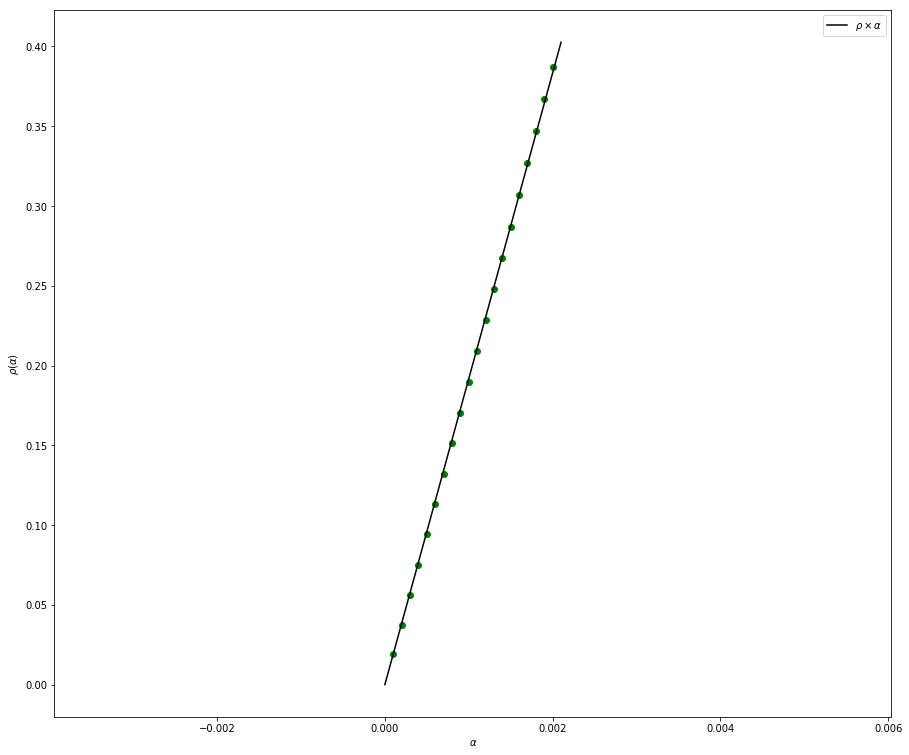

In [61]:
def func(x,a): # função para ser passada como argumento de curve_fit
    return a*x

rho = [] # lista para guardar os valores de rho(alpha)
vet_alpha = np.arange(0.0001,0.0021,0.0001) # array com os valores de alpha usados para obter os rhos

for i in range(len(vet_alpha)): # loop para o fit de cada um dos thetas em função de alpha
    x,y,xf,yf,t_theta = simula(vet_alpha[i]) # simulação para cada um dos alphas
    theta = cal_theta(xf,yf) # calculo de theta
    rho_l = list(op.curve_fit(func,t_theta,theta)) # a função curve_fit retorna uma tupla de arrays,logo precisa
    rho.append(list(rho_l[0])) # ser convertida pra lista; nesta linha converte-se o array para o rho em uma lista

rho_2 = [] # lista para os valores de rho, já que rho é uma lista que contém os valores dentro de listas separadas
for i in range(len(vet_alpha)): # conversão 
    rho_2.append(rho[i][0])
    
c = list(op.curve_fit(func,vet_alpha,rho_2))#linearização dos dados de rho(alpha) para obtenção do coeficiente angular c
c = list(c[0]) # como o fit retorna uma lista de dois arrays, pega-se o primeiro array e o converte para lista
# que corresponde ao valor de c

plt.figure(figsize=(15,13)) # plot de rho por alpha
plt.scatter(vet_alpha,rho,color = 'green')
fit_alpha = np.arange(0,0.0022,0.0001) # array de valores para o plot da curva
fit_rho = c*fit_alpha # rho = c*alpha
k_2,= plt.plot(fit_alpha,fit_rho,label = r'$\rho \times \alpha$',color = 'black')#plot da curva fitada
plt.legend(handles=[k_2,])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\rho(\alpha)$')

plt.show()

O resultado esperado para a precessão relativística será o valor de $\alpha$ para o mercúrio multiplicado por c. Depois o valor deve ser convertido de radianos para graus e arco-segundo por século.

In [62]:
resultado = c[0]*1.1*10**(-8)
resultado = resultado*(180/np.pi)*3600*100
print(resultado)

43.501201814075166


 O valor obtido, 43.501201814075166, corresponde bem ao valor esperado, 43, dentro dos limites de precisão dos cálculos. Logo o método utilizado confirma a previsão relativística para a precessão de Mercúrio.